## TODO:
* Train on circles
* Save results
* Describe training
* Write README
    * Propose future work
    * Summarize project
    * Connect to phd

## Imports

In [257]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as data
import os
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms import v2
import torch


## Data Generation

<class 'numpy.ndarray'>


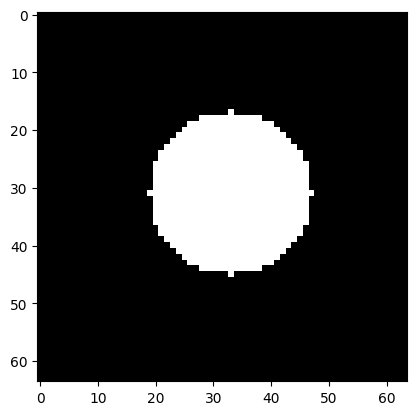

In [330]:
def generate_random_shape(size, shape=None):
    """
    Generates an image containing a random geometric shape (rectangle, circle).

    This function creates a grayscale image of the specified size and draws a random shape on it.
    If no specific shape is provided, the function randomly selects one from the available shapes.

    Args:
        size (int): The size of the square image (e.g., 64 for a 64x64 image).
        shape (str, optional): The desired shape to draw. Options are 'rectangle', 'circle'.
                               If None, a shape is chosen randomly.

    Returns:
        numpy.ndarray: A 2D array representing the generated grayscale image with the drawn shape.
    """
    img = np.zeros(shape=(size, size), dtype=np.uint8)
    if not shape:
        shapes = ['rectangle', 'circle']
        shape = np.random.choice(shapes)
        thickness = np.random.choice([2,-1])
    thickness = -1

    color = np.random.randint(0,255)
    
    if shape == 'rectangle':
        
        x1, y1 = np.random.randint(10, 20, size=2)
        x2, y2 = np.random.randint(40, 50, size=2)
        
        return cv.rectangle(img, pt1=(x1,y1),pt2=(x2,y2),color=color, thickness=thickness)
    elif shape == 'circle':

        x, y = np.random.randint(30,35,size=2)
        radius = np.random.randint(14,15)
        
        return cv.circle(img, center=(x, y), radius=radius, color=color, thickness=thickness)
print(type(generate_random_shape(64,shape='circle')))
plt.imshow(generate_random_shape(64,shape='circle'), cmap='grey')

In [331]:
for i in range(3000):
    plt.imsave(f'./data/data_circle_3000/img_{i}.png',generate_random_shape(64,shape='circle'),cmap='grey')

In [163]:
for i in range(3000):
    plt.imsave(f'./data/data_w_lines_3000/img_{i}.png',generate_random_shape(64),cmap='grey')

for i in range(3000):
    plt.imsave(f'./data/data_3000/img_{i}.png',generate_random_shape(64),cmap='grey')

[1510 2462 1677 1689 2477 2560 2511  837]


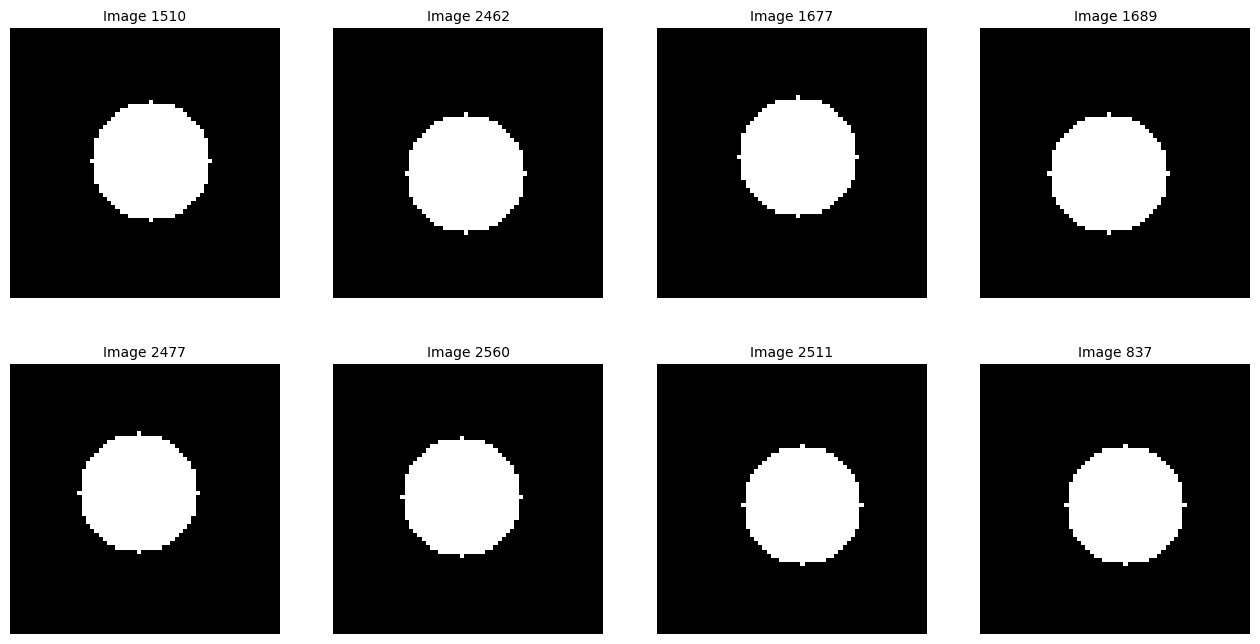

In [340]:
imgs_idx = np.random.choice(range(3000),size=(8))
print(imgs_idx)

figure1 = plt.figure(figsize=(16,8))
i=0
for idx in imgs_idx:

    img = cv.imread(f'./data/data_circle_3000/img_{idx}.png', cv.IMREAD_GRAYSCALE)
    
    ax = figure1.add_subplot(2, 4, i+1)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {idx}', fontsize=10)
    i += 1
    


In [341]:
class image_dataset(data.Dataset):
    """
    A custom PyTorch dataset for loading and preprocessing grayscale images.

    This dataset is designed to load images from a specified directory, decode them 
    as grayscale images using torchvision's `decode_image`, and optionally normalize 
    the pixel values.

    Attributes:
        path (str): The directory path containing the image files.
        normalize (bool): Whether to normalize the images. Default is True.

    Methods:
        __getitem__(idx):
            Retrieves the image at the specified index, decodes it as a grayscale image, 
            and applies normalization if enabled.
        
        __len__():
            Returns the total number of image files in the specified directory.
    """
    def __init__(self, path, normalize=True):
        self.normalize = normalize
        self.path = path
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.path,f'img_{idx}.png')
        image = decode_image(img_path,mode=ImageReadMode.GRAY).float()
        if self.normalize:
            normalizer = v2.Normalize(mean=[0], std=[1])
            image = normalizer(image)
        return image
    def __len__(self):
        return len([f for f in os.listdir(self.path) if os.path.isfile(os.path.join(self.path, f))])

img_data = image_dataset('/Users/marcusandersson/Documents/Basic-Diffusion-Model-Demo/data/data_rect_3000')
img_data_circl = image_dataset('/Users/marcusandersson/Documents/Basic-Diffusion-Model-Demo/data/data_circle_3000')
train_dataloader = data.DataLoader(img_data, batch_size=32, shuffle=True)
train_dataloader_circle = data.DataLoader(img_data_circl, batch_size=32, shuffle=True)

## Model architecture

The model used to predict the noise at each timestep is a U-Net architetcture with skip connections and timestep injection.

#### Input:
I takes a noisy image of size 64 x 64 pixels with 1 channel and a scalar timestep t as input

#### Encoder:
The input is then downsamples throug as series of encoder blocks. Each of the encoder blocks consists two convolutional layers with ReLU activation and finally a max-pooling layer to reduce the spatial dimensions while increasing number of feature channels. Before pooling the feature channels are sotred to be used as skip connections.

#### Timestep embedding:
The timestep embedding is preformed using a small multi layer perceptron. Which transforms the scalat timestep t into a 512-dimensional timestep embedding vector.

#### Bottelneck:
After the encoder the features are passed through the bottelneck block which expands the featrues from 512 channels to 1024. In this step the time embedding is also injected by adding it to the feature map. This allows the model to condition its noise prediction on the timestep.

#### Decoder:
The features are the upsamples through a series of decoder blocks. Each block preforms a transposed convolution and then concatenates the features with the skip connections from the encoder. This is done to recover fine-grained spatial details that is lost during downsampling.

#### Output:
The final output layer maps the 64 channels from the decoder to the same dimension as th input (64 x 64).


In [ ]:


class ConvolutionBlock(nn.Module):
    """
    A convolutional block consisting of two convolutional layers with ReLU activation.

    This block applies two 2D convolutional layers with a kernel size of 3, followed by ReLU activation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Methods:
        forward(x):
            Applies the convolutional layers to the input tensor.

    Returns:
        torch.Tensor: The output tensor after applying the convolutional layers and activation.
    """
    def __init__(self, in_channels, out_channels):
        super(ConvolutionBlock, self).__init__()
        
        self.conv_in = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=3)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        
        x = self.conv_in(x)
        x = self.relu(x)
        x = self.conv_out(x)
        x = self.relu(x)

        return x

class EncoderBlock(nn.Module):
    """
    An encoder block consisting of a convolutional block followed by max pooling.

    This block extracts features using a convolutional block and reduces spatial dimensions using max pooling.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Methods:
        forward(x):
            Applies the convolutional block and max pooling to the input tensor.

    Returns:
        tuple: A tuple containing:
            - x (torch.Tensor): The feature map after the convolutional block.
            - p (torch.Tensor): The pooled feature map.
    """
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvolutionBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    """
    A decoder block consisting of an upsampling layer followed by a convolutional block.

    This block upsamples the input tensor using a transposed convolution, concatenates it with skip features,
    and refines the features using a convolutional block.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Methods:
        forward(x, skip_features):
            Upsamples the input tensor, concatenates it with skip features, and applies the convolutional block.

    Returns:
        torch.Tensor: The refined feature map.
    """
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvolutionBlock(in_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat((x, skip_features), dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    """
    A U-Net architecture with skip connections and timestep embedding for diffusion models.

    This U-Net consists of an encoder, bottleneck, and decoder. It incorporates a timestep embedding
    to condition the model on the diffusion timestep.

    Args:
        time_dim (int): Dimensionality of the timestep input.

    Methods:
        forward(x, t):
            Performs a forward pass through the U-Net.

    Returns:
        torch.Tensor: The output tensor with the same spatial dimensions as the input.
    """
    def __init__(self, time_dim=1):
        super(UNet, self).__init__()

        self.time_mlp = nn.Sequential(
                    nn.Linear(time_dim, 256),
                    nn.ReLU(),
                    nn.Linear(256, 512)
        )

        self.enc1 = EncoderBlock(1, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = ConvolutionBlock(512, 1024)
        

        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        """
        Performs a forward pass through the U-Net.

        Args:
            x (torch.Tensor): The input tensor of shape [batch_size, 1, height, width].
            t (torch.Tensor): The timestep tensor of shape [batch_size].

        Returns:
            torch.Tensor: The output tensor of shape [batch_size, 1, height, width].
        """
        # Encode timestep
        t = t.float().unsqueeze(-1)  # Shape: [batch_size, 1]
        t_emb = self.time_mlp(t)  # Shape: [batch_size, 1024]
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, 1024, 1, 1]


        # Encoder
        enc1, p1 = self.enc1(x)
        enc2, p2 = self.enc2(p1)
        enc3, p3 = self.enc3(p2)
        enc4, p4 = self.enc4(p3)

        # Bottleneck
        bottleneck = self.bottleneck(p4 + t_emb)  # Inject timestep embedding

        # Decoder
        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)

        # Final layer
        return self.final(dec1)

## Diffusion Process

#### Variance schedule
The variance schedule is used to control how much noise is added at each timestep. Here a linear and cosine schedule have been implemented. The cosin schedule was proposed by ([Nichol & Dhariwal(2021)](https://arxiv.org/abs/2102.09672)) as an improvment to help diffusion models achieve lower NLL.

#### Forward process
The forward diffusion process adds a small amount of random noise to the input in T timesteps. This results in a series of noisy images where the last image conists of random noise. The amount of noise added at each timestep is controlled by the variance schedule.

#### Backward process
In the backward process, a sample is drawn from Gaussian noise. Then at each timestep a neural network is used to predict the noise that was added in the forward process between two timestep. The predicted noise is then removed from the current sample. After doing this T times, we ideally end up with an image similar to that of the inout in the forward process

In [ ]:
class Diffusion:
    """
    A class implementing the diffusion process for generative modeling.

    This class defines the forward and backward diffusion processes, as well as the 
    variance schedule used to control the noise levels at each timestep.

    Attributes:
        timesteps (int): The total number of timesteps in the diffusion process.
        beta (torch.Tensor): The noise variance schedule for each timestep.
        alpha (torch.Tensor): The complement of beta (1 - beta) for each timestep.
        alpha_bar (torch.Tensor): The cumulative product of alpha over timesteps.

    Methods:
        loss(noise, predicted_noise):
            Computes the mean squared error (MSE) loss between the true noise and the predicted noise.

        forward(x0, t):
            Simulates the forward diffusion process by adding noise to the input data `x0` 
            at a given timestep `t`.

        backward(model, x_t, t):
            Simulates the backward diffusion process by predicting the posterior mean 
            using the model's predicted noise at a given timestep `t`.
    """
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02, variance_schedule='linear'):
        """
        Initializes the Diffusion class with the specified variance schedule.

        Args:
            timesteps (int): The total number of timesteps in the diffusion process.
            beta_start (float): The starting value of the noise variance.
            beta_end (float): The ending value of the noise variance.
            variance_schedule (str): The type of variance schedule to use ('linear' or 'cosine').

        Raises:
            ValueError: If an unsupported variance schedule is provided.
        """
        self.timesteps = timesteps

        if variance_schedule == 'linear':
            self.beta = torch.linspace(beta_start, beta_end, timesteps, device='mps')
        elif variance_schedule == 'cosine':
            s = 0.008  # Small constant to prevent division by zero
            x = torch.linspace(0, timesteps, timesteps + 1, device='mps')
            alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            self.alpha_bar = alphas_cumprod[:-1]
            self.beta = 1 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
            self.beta = torch.cat((self.beta, torch.tensor([beta_end], device='mps')))
        else:
            raise ValueError("Unsupported variance schedule. Use 'linear' or 'cosine'.")
        
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def loss(self, noise, predicted_noise):
        """
        Computes the mean squared error (MSE) loss between the true noise and the predicted noise.

        Args:
            noise (torch.Tensor): The true noise added during the forward process.
            predicted_noise (torch.Tensor): The noise predicted by the model.

        Returns:
            torch.Tensor: The computed MSE loss.
        """
        return torch.nn.functional.mse_loss(noise, predicted_noise)

    def forward(self, x0, t):
        """
        Simulates the forward diffusion process by adding noise to the input data `x0` 
        at a given timestep `t`.

        Args:
            x0 (torch.Tensor): The original input data.
            t (int): The current timestep.

        Returns:
            tuple: A tuple containing:
                - x_t (torch.Tensor): The noisy data at timestep `t`.
                - noise (torch.Tensor): The noise added to the input data.
        """
        noise = torch.randn_like(x0, device='mps')

        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t]).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        sqrt_alpha_bar_ = torch.sqrt(1 - self.alpha_bar[t]).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        
        x_t = sqrt_alpha_bar * x0 + sqrt_alpha_bar_ * noise
       
        return x_t, noise

    def backward(self, model, x_t, t):
        """
        Simulates the backward diffusion process by predicting the posterior mean 
        using the model's predicted noise at a given timestep `t`.

        Args:
            model (torch.nn.Module): The model used to predict the noise.
            x_t (torch.Tensor): The noisy data at timestep `t`.
            t (int): The current timestep.

        Returns:
            tuple: A tuple containing:
                - posterior_mean (torch.Tensor): The predicted posterior mean.
                - predicted_noise (torch.Tensor): The noise predicted by the model.
        """
        predicted_noise = model(x_t, t)

        beta_t = self.beta[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
        alpha_t = self.alpha[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
        alpha_bar_t = self.alpha_bar[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)

        sqrt_alpha = torch.sqrt(alpha_t)
        sqrt_alpha_bar_ = torch.sqrt(1 - alpha_bar_t)

        posterior_mean = (1/sqrt_alpha) * (x_t - beta_t * predicted_noise / sqrt_alpha_bar_)

        return posterior_mean, predicted_noise

## Training

First the diffusion process, U-Net model and optimizer are instantiated. Here I use the Adam optimizer.

The training loop consists of 5 main steps for each bach in the dataloader:
 1. Simulate the forwards diffusion process
 2. Predict the added noise at each timestep
 3. Calculate the loss
 4. Backpropagation
 5. Optimizer step



In [342]:
device = 'mps'
epochs = 20
timesteps = 1000

learning_rate = 0.0001

diffusion = Diffusion(timesteps=timesteps,variance_schedule='cosine')

UNet_model = UNet()
UNet_model.to(device)

optimizer = torch.optim.Adam(UNet_model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    UNet_model.train()
    for step, batch in enumerate(train_dataloader_circle):
        batch = batch.to(device)
        t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()
        x_t, noise = diffusion.forward(batch, t)
        predicted_noise = UNet_model(x_t,t)
        loss = diffusion.loss(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1==0:
        print(f'Epoch {epoch} | Loss: {loss.item()}')

Epoch 0 | Loss: 0.5574134588241577
Epoch 1 | Loss: 0.3059523105621338
Epoch 2 | Loss: 0.29243212938308716
Epoch 3 | Loss: 0.19210627675056458
Epoch 4 | Loss: 0.21926121413707733
Epoch 5 | Loss: 0.2329452484846115
Epoch 6 | Loss: 0.184146448969841
Epoch 7 | Loss: 0.19552426040172577
Epoch 8 | Loss: 0.19890157878398895
Epoch 9 | Loss: 0.15608374774456024
Epoch 10 | Loss: 0.16379669308662415
Epoch 11 | Loss: 0.1710270643234253
Epoch 12 | Loss: 0.1647782176733017
Epoch 13 | Loss: 0.13114780187606812
Epoch 14 | Loss: 0.11656062304973602
Epoch 15 | Loss: 0.08674132823944092
Epoch 16 | Loss: 0.09412853419780731
Epoch 17 | Loss: 0.11592745780944824
Epoch 18 | Loss: 0.07213245332241058
Epoch 19 | Loss: 0.14240096509456635


## Sampling

In [356]:
def sample(diffusion, model, shape, timesteps, device='mps'):
    """
    Generates samples from a diffusion model by iteratively denoising random noise.

    This function starts with random noise and applies the backward diffusion process
    iteratively for the specified number of timesteps to generate samples.

    Args:
        diffusion (Diffusion): The diffusion process object that defines the backward process.
        model (torch.nn.Module): The trained model used to predict noise at each timestep.
        shape (tuple): The shape of the output tensor (e.g., (batch_size, channels, height, width)).
        timesteps (int): The total number of timesteps in the diffusion process.
        device (str, optional): The device to run the sampling on (default is 'mps').

    Returns:
        torch.Tensor: The generated samples with the specified shape.
    """
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(shape, device=device)  # Start with random noise
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            x_t, _ = diffusion.backward(model, x_t, t_tensor)
        return x_t

# Example usage
#sampled_images = sample(diffusion, UNet_model, shape=(8, 1, 64, 64), timesteps=timesteps, device=device)
#sampled_images_circle = sample(diffusion, UNet_model, shape=(8, 1, 64, 64), timesteps=timesteps, device=device)
# sampled_images_circle_t100 = sample(diffusion, UNet_model, shape=(8, 1, 64, 64), timesteps=100, device=device)
sampled_images_circle_t500 = sample(diffusion, UNet_model, shape=(8, 1, 64, 64), timesteps=950, device=device)

### Generated images - Rectangle DO NOT RERUN

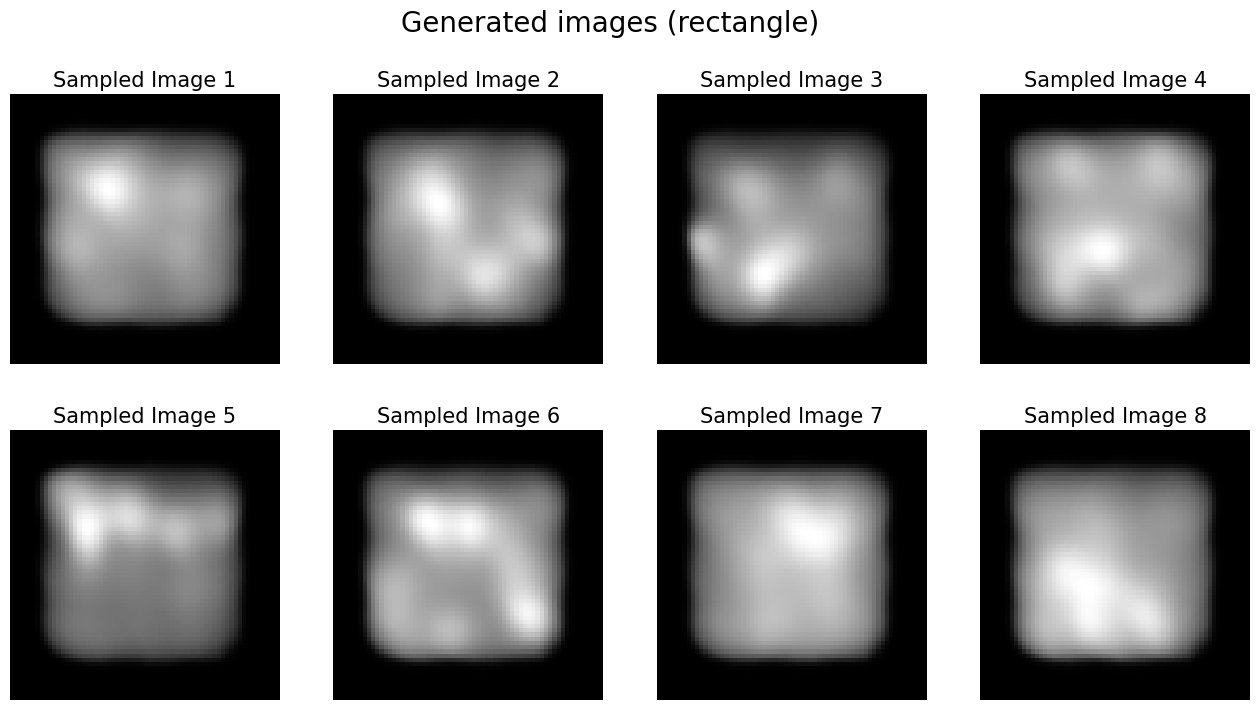

In [302]:

# Visualize the sampled images
figure = plt.figure(figsize=(16, 8))
figure.suptitle('Generated images (rectangle)',fontsize=20)
figure.tight_layout()
for i in range(8):
    ax = figure.add_subplot(2, 4, i + 1)
    ax.imshow(sampled_images[i, 0].cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sampled Image {i+1}', fontsize=15)
plt.show()

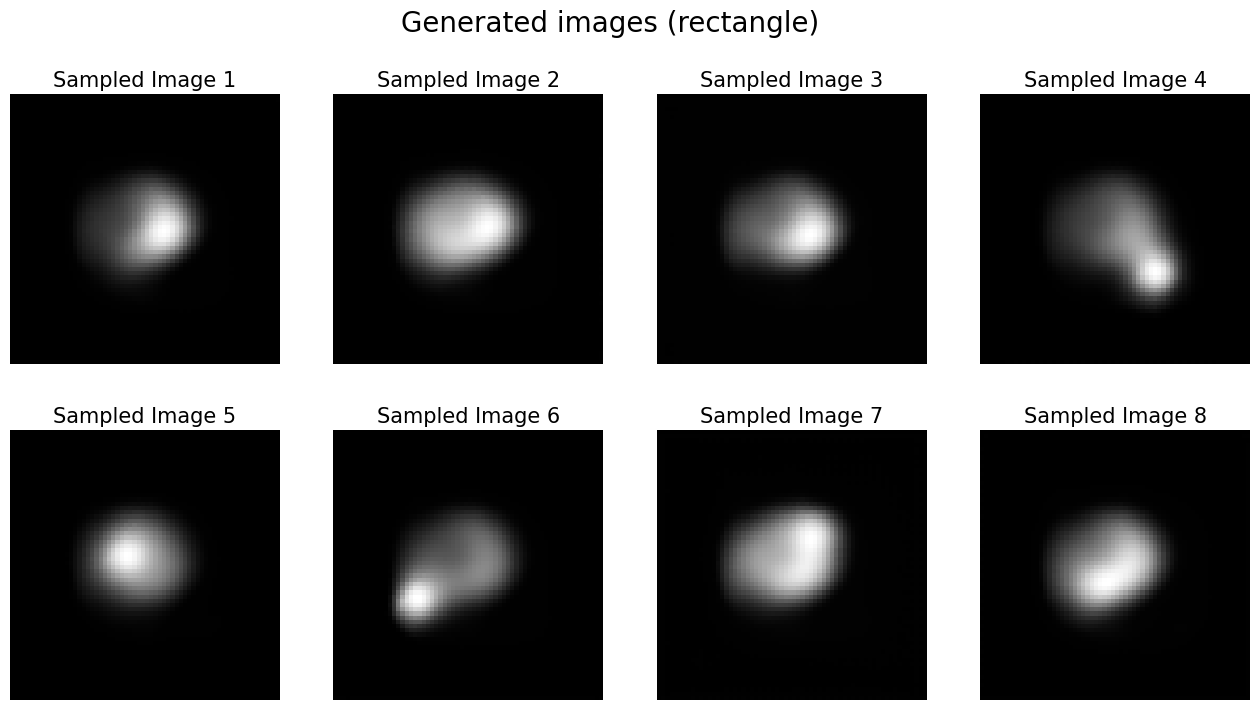

In [347]:

# Visualize the sampled images
figure = plt.figure(figsize=(16, 8))
figure.suptitle('Generated images (rectangle)',fontsize=20)
figure.tight_layout()
for i in range(8):
    ax = figure.add_subplot(2, 4, i + 1)
    ax.imshow(sampled_images_circle[i, 0].cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sampled Image {i+1}', fontsize=15)
plt.show()

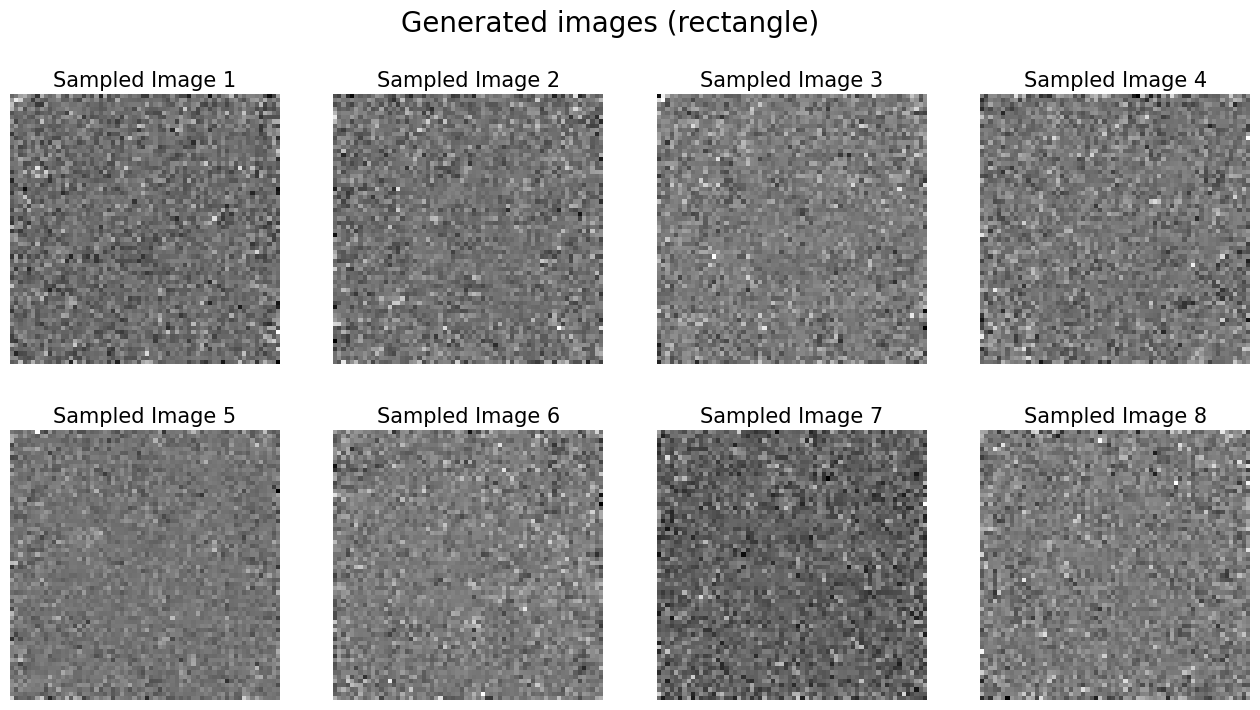

In [349]:
# Visualize the sampled images
figure = plt.figure(figsize=(16, 8))
figure.suptitle('Generated images (rectangle)',fontsize=20)
figure.tight_layout()
for i in range(8):
    ax = figure.add_subplot(2, 4, i + 1)
    ax.imshow(sampled_images_circle_t100[i, 0].cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sampled Image {i+1}', fontsize=15)
plt.show()

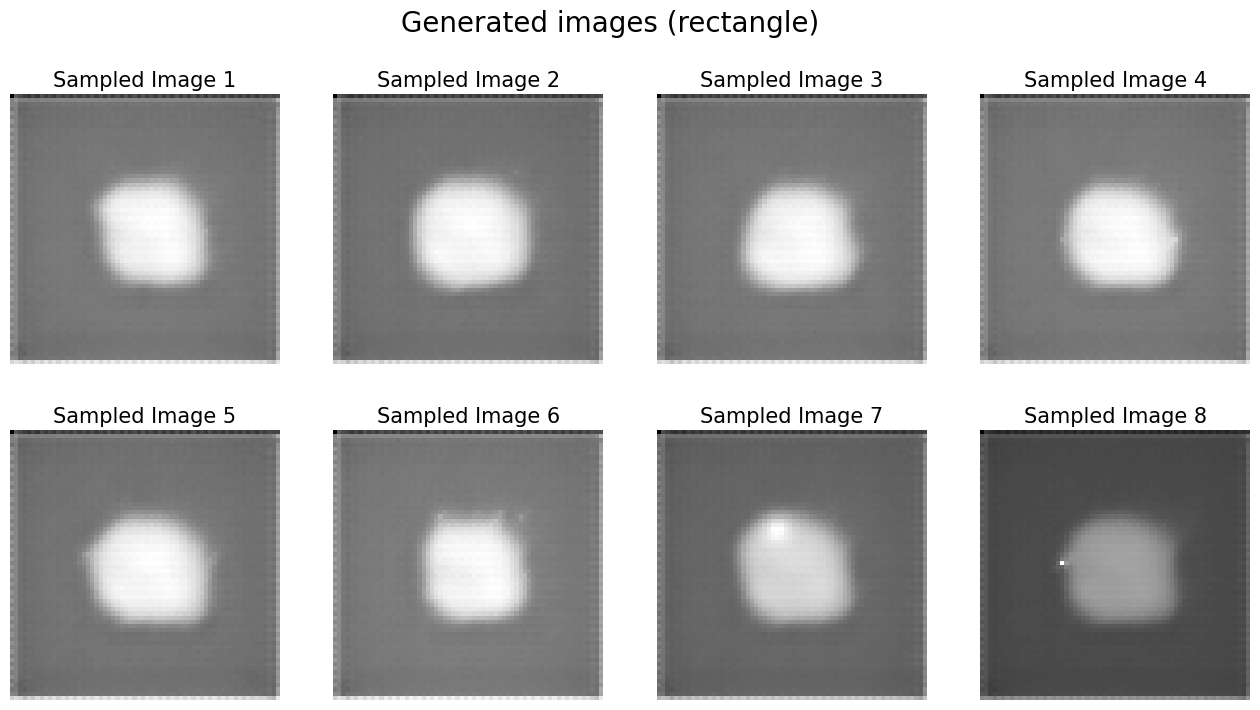

In [357]:
# Visualize the sampled images
figure = plt.figure(figsize=(16, 8))
figure.suptitle('Generated images (rectangle)',fontsize=20)
figure.tight_layout()
for i in range(8):
    ax = figure.add_subplot(2, 4, i + 1)
    ax.imshow(sampled_images_circle_t500[i, 0].cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sampled Image {i+1}', fontsize=15)
plt.show()